In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from random import random

In [14]:
model = torch.nn.Sequential(
    torch.nn.Linear(8, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 4)
)

loss_fn = torch.nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("LunarLander-v2", render_mode=None)

simulation_len = 10000
obs_, _ = env.reset()
obs = torch.from_numpy(obs_).float()

observations = np.nan * np.ones(shape=(simulation_len+1, 8))
actions = np.nan * np.ones(shape=(simulation_len+1,))
rewards = np.nan * np.ones(shape=(simulation_len+1,))

time = np.array(range(simulation_len+1))

In [16]:
gamma = 0.9
epsilon = 1.0

gains = []
g = 0
episode = 0
while True:

    # 1. Choose action
    # ================

    # a = env.action_space.sample()
    q = model(obs)
    if random() < epsilon:
        a = env.action_space.sample()
    else:
        a = torch.argmax(q).item()

    # 2. Apply action. Collect rewards
    obs_, r, terminated, truncated, _ = env.step(a)
    g += r
    obs = torch.from_numpy(obs_).float()

    with torch.no_grad():
        next_q = model(obs)
        next_q_max = torch.argmax(next_q)

    if terminated or truncated:
        obs_, _ = env.reset()
        episode += 1
        print(f"episode/gain = {episode}/{g}")
        if g >= 200:
            print(f"SUCCESS")
        g = 0
        if episode > 2000:
            break
        obs = torch.from_numpy(obs_).float()
        target = float(r)
    else:
        target = float(r) + gamma*next_q_max

    Y = torch.tensor([target]).detach()
    X = q[a]
    loss = loss_fn(X, Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epsilon = 0.8 - 0.005*episode
    if epsilon < 0.1:
        epsilon = 0.1

env.close()

episode/gain = 1/-423.649837912569
episode/gain = 2/-89.33044265419916
episode/gain = 3/-38.11398413774354
episode/gain = 4/-290.80742438000317
episode/gain = 5/-62.97165005582015
episode/gain = 6/-369.33570487507836
episode/gain = 7/-363.53198136751473
episode/gain = 8/-470.92360586629644
episode/gain = 9/-308.19970641484304
episode/gain = 10/-259.2485176940312
episode/gain = 11/-296.1897191494321
episode/gain = 12/-211.7167807816994
episode/gain = 13/-282.1325373592014
episode/gain = 14/12.007868821997818
episode/gain = 15/-109.32696750823725
episode/gain = 16/-118.42537046153308
episode/gain = 17/-216.23142078084243
episode/gain = 18/-491.9951508406592
episode/gain = 19/-550.0769233303824
episode/gain = 20/-302.5160061681507
episode/gain = 21/-343.52457353362524
episode/gain = 22/-309.4367728111438
episode/gain = 23/-468.5087659146297
episode/gain = 24/-284.10178164475303
episode/gain = 25/-38.49603057035647
episode/gain = 26/-115.06542659089918
episode/gain = 27/-4.616819107835283


KeyboardInterrupt: 

In [17]:
episode = 0
g = 0

env = gym.make("LunarLander-v2", render_mode='human')
obs_, _ = env.reset()
obs = torch.from_numpy(obs_).float()

while True:

    q = model(obs)
    a = torch.argmax(q).item()

    # 2. Apply action. Collect rewards
    obs_, r, terminated, truncated, _ = env.step(a)
    g += r
    obs = torch.from_numpy(obs_).float()

    if terminated or truncated:
        obs_, _ = env.reset()
        episode += 1
        print(f"episode/gain = {episode}/{g}")
        if g >= 200:
            print(f"SUCCESS")
        g = 0
        if episode > 1000:
            break
        obs = torch.from_numpy(obs_).float()

env.close()

episode/gain = 1/154.44410372478353
episode/gain = 2/-232.44916387382102
episode/gain = 3/-286.10764987550607
episode/gain = 4/-104.76096214233348
episode/gain = 5/170.46847348016843
episode/gain = 6/-209.59259255947774
episode/gain = 7/113.23899699240049
episode/gain = 8/153.36607892912883
episode/gain = 9/-89.99177755712385
episode/gain = 10/-257.27835560835956
episode/gain = 11/-164.09428392793308
episode/gain = 12/180.35513396211027
episode/gain = 13/-25.805416926208068
episode/gain = 14/-51.062699917860755
episode/gain = 15/222.134400389686
SUCCESS
episode/gain = 16/-232.64768093105693


KeyboardInterrupt: 

Text(0.5, 1.0, 'Total gain: -14689.88')

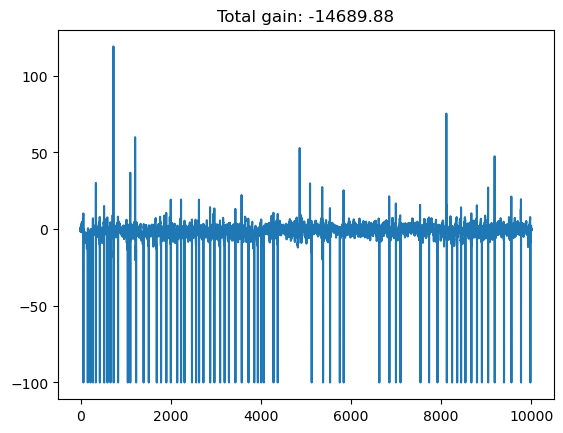

In [61]:
g = np.sum(rewards)
plt.plot(time, rewards);
plt.title(f"Total gain: {g:4.2f}")

In [46]:
actions = np.array(actions)
left_engine = actions == 1
main_engine = actions == 2
right_engine = actions == 3

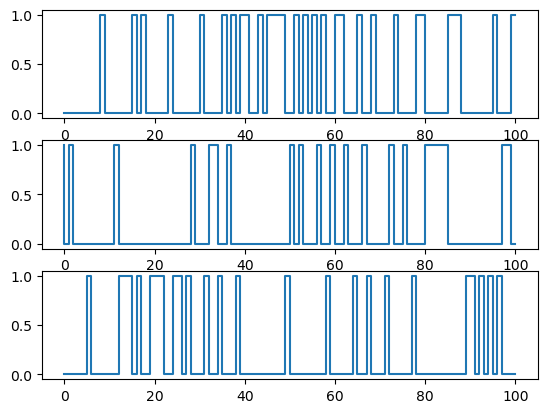

In [53]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.step(time, left_engine)
# ax1.set_title("left engine")
ax2.step(time, main_engine)
# ax2.set_title("main engine")
ax3.step(time, right_engine);
# ax3.set_title("right engine");

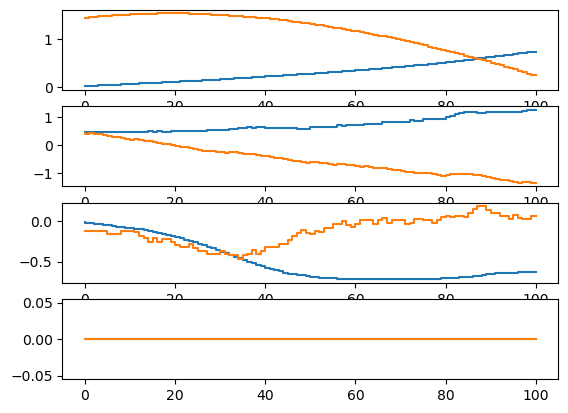

In [56]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.step(time, observations[:, :2])
# ax1.set_title("positions")
ax2.step(time, observations[:, 2:4])
# ax2.set_title("velocities")
ax3.step(time, observations[:, 4:6]);
# ax3.set_title("angular position and velocity");
ax4.step(time, observations[:, 6:8]);
# ax3.set_title("landing sensors");